In [ ]:
# Make sure you use the Colab GPU to run the testing phase

import torch
torch.cuda.is_available()

False

In [ ]:
# Show the GPU info

!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [48]:
!gdown --id '1lrKueI4HrySQDGvpkilQN9BfaMUN7hZi' --output train.zip

!apt-get install unzi
!unzip -q 'train.zip' -d train

!gdown --id '1Fm-avdeNgzhPxhvia0iw9yZzcoOggy7I' --output test.zip
!unzip -q 'test.zip' -d test

Downloading...
From: https://drive.google.com/uc?id=1lrKueI4HrySQDGvpkilQN9BfaMUN7hZi
To: /content/mmdetection/checkpoints/train.zip
100% 420M/420M [00:02<00:00, 146MB/s]
^C
Downloading...
From: https://drive.google.com/uc?id=1Fm-avdeNgzhPxhvia0iw9yZzcoOggy7I
To: /content/mmdetection/checkpoints/test.zip
100% 273M/273M [00:03<00:00, 71.6MB/s]


In [51]:
# Git clone your project

!git clone https://github.com/open-mmlab/mmdetection.git
!git clone https://github.com/open-mmlab/mmcv.git

Cloning into 'mmdetection'...
remote: Enumerating objects: 21852, done.
remote: Total 21852 (delta 0), reused 0 (delta 0), pack-reused 21852
Receiving objects: 100% (21852/21852), 25.21 MiB | 14.21 MiB/s, done.
Resolving deltas: 100% (15334/15334), done.
Cloning into 'mmcv'...
remote: Enumerating objects: 9037, done.
remote: Counting objects: 100% (2332/2332), done.
remote: Compressing objects: 100% (1230/1230), done.
remote: Total 9037 (delta 1372), reused 1555 (delta 1051), pack-reused 6705
Receiving objects: 100% (9037/9037), 8.89 MiB | 13.88 MiB/s, done.
Resolving deltas: 100% (6116/6116), done.


In [53]:
# Install your requirments (torch, mmcv, ...)
# It is recommended that you wirte the requirements.txt file in your project.

%cd mmdetection

!pip install mmcv-full

!pip install -e .

!pip install googledrivedownloader

[Errno 2] No such file or directory: 'mmdetection'
/content/mmdetection/checkpoints/mmdetection
Obtaining file:///content/mmdetection/checkpoints/mmdetection
  Attempting uninstall: mmdet
    Found existing installation: mmdet 2.18.1
    Can't uninstall 'mmdet'. No files were found to uninstall.
  Running setup.py develop for mmdet


In [ ]:
# Import your package and check the version

%cd mmdetection

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import mmdet
print(mmdet.__version__)

import mmcv
print(mmcv.__version__)

from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# You must import the below 5 packages 
import os
import cv2
import time
from tqdm import tqdm
from google_drive_downloader import GoogleDriveDownloader as gdd

# Convert Dataset to COCO format 

In [ ]:
# ref:https://stackoverflow.com/questions/41176258/h5py-access-data-indatasets-in-svhn/41264930
# ref:https://mmdetection.readthedocs.io/en/latest/tutorials/customize_dataset.html
# ref:https://mmdetection.readthedocs.io/en/latest/2_new_data_model.html
# Deal with the .mat file
import cv2
import h5py
import torchvision.models as models
from tqdm.auto import tqdm
import tqdm
import json
import mmcv
import numpy as np

%cd mmdetection
def get_box_data(index, hdf5_data):
  meta_data = dict()
  meta_data['height'] = []
  meta_data['label'] = []
  meta_data['left'] = []
  meta_data['top'] = []
  meta_data['width'] = []

  def print_attrs(name, obj):
    vals = []
    if obj.shape[0] == 1:
      vals.append(obj[0][0])
    else:
      for k in range(obj.shape[0]):
        vals.append(int(hdf5_data[obj[k][0]][0][0]))
    meta_data[name] = vals

  box = hdf5_data['/digitStruct/bbox'][index]
  hdf5_data[box[0]].visititems(print_attrs)
  return meta_data

def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]][:]])

mat_data = h5py.File('/content/mmdetection/train/train/digitStruct.mat')
#mat_data = h5py.File('/content/train/train/digitStruct.mat')
size = mat_data['/digitStruct/name'].size
images=list()
annotations=list()
object_count=0
for _i in tqdm.tqdm(range(size)):
    pic = get_name(_i, mat_data)
    box = get_box_data(_i, mat_data)
    filename = "/content/mmdetection/train/train/"+pic
    image = mmcv.imread(filename)
    height, width = image.shape[:2]
    id_no = _i
    #middle_dict = dict(filename="train/train/"+pic, width=width, height=height)
    images.append(dict(
        id=id_no,
        file_name=pic,
        height=height,
        width=width))
# load annotations
    for i in range(len(box["height"])):
      poly = [(box['left'][i], box['top'][i]), (box['left'][i] + box['width'][i], box['top'][i]),
            (box['left'][i] + box['width'][i], box['top'][i] + box['height'][i]), (box['left'][i], box['top'][i] + box['height'][i])]
      poly = [float(p) for x in poly for p in x]
      anno = dict(
          image_id = _i,
          id = object_count,
          category_id = box["label"][i],
          bbox=[box['left'][i], box['top'][i], box['width'][i], box['height'][i]],
          area=height*width,
          segmentation=[poly],
          iscrowd=0)
      annotations.append(anno)
      object_count += 1
      
coco_format = dict(
        images=images,
        annotations=annotations,
        categories=[{'id': i, 'name': str(i if i % 10 else 0)} for i in range(1, 11)])
json_object = json.dumps(coco_format, indent=4)

%cd content
with open("digitStruct.json", "w") as outfile:
    outfile.write(json_object)


[Errno 2] No such file or directory: 'mmdetection'
/content/mmdetection/checkpoints


100%|██████████| 33402/33402 [05:32<00:00, 100.58it/s]


[Errno 2] No such file or directory: 'content'
/content/mmdetection/checkpoints


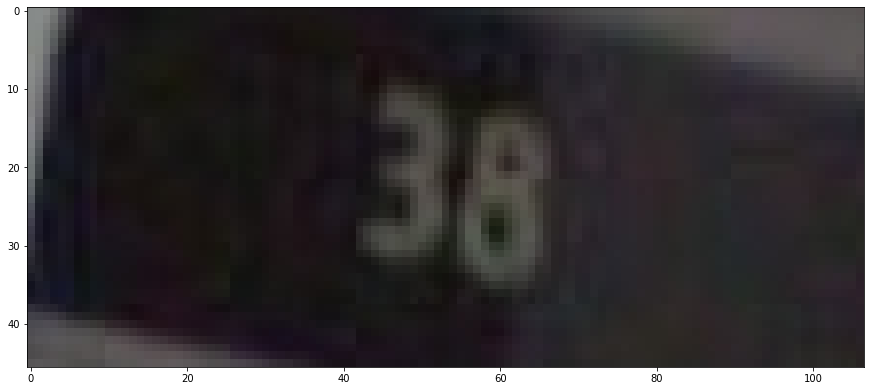

In [ ]:
import mmcv
import matplotlib.pyplot as plt
img=mmcv.imread("/content/mmdetection/test/test/117.png")
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()
)


In [ ]:
import os
dir = "/content/mmdetection/test/test/"
test_json= "/content/mmdetection/test.json"
images = list()
for filename in os.listdir(dir):
  images.append(dict(
      file_name=filename,
      id=filename.rstrip('.jpg')
  ))

json_object = json.dumps(coco_format, indent=4)

with open(test_json, "w") as outfile:
    outfile.write(json_object)

## Download Pretrained Model

In [ ]:
%cd mmdetection
%mkdir checkpoints
%cd checkpoints

#!wget https://download.openmmlab.com/mmdetection/v2.0/configs/fast_rcnn/fast_rcnn_r50_fpn_1x_coco.py

config = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'

!wget https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

[Errno 2] No such file or directory: 'mmdetection'
/content/mmdetection
/content/mmdetection/checkpoints
--2021-11-26 10:48:27--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.5
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

faster_rcnn_r50_fpn 100%[===================>] 159.54M  13.0MB/s    in 13s     

2021-11-26 10:48:41 (12.1 MB/s) - ‘faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



# Start Training

In [ ]:
# The new config inherits a base config to highlight the necessary modification
_base_ = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'

# We also need to change the num_classes in head to match the dataset's annotation
model = dict(
    roi_head=dict(
        bbox_head = dict(num_classes=10),
        mask_head = dict(num_classes=10)))

# Modify dataset related settings
dataset_type = 'COCODataset'
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9',)
data = dict(
    train = dict(
        img_prefix = '/content/mmdetection/train/train/',
        classes = classes,
        ann_file = '/content/mmdetection/checkpoints/digitStruct.json'),
    val = dict(
        img_prefix = '/content/mmdetection/test/test/',
        classes = classes,
        ann_file = '/content/mmdetection/test.json'),
    test = dict(
        img_prefix = '/content/mmdetection/test/test/',
        classes = classes,
        ann_file = '/content/mmdetection/test.json'))

# We can use the pre-trained Mask RCNN model to obtain higher performance
load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [ ]:
from mmdet.apis import init_detector, inference_detector
import mmcv

# Specify the path to model config and checkpoint file
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

# test a single image and show the results
img = '1.png'  # or img = mmcv.imread(img), which will only load it once
result = inference_detector(model, img)
# visualize the results in a new window
model.show_result(img, result)
# or save the visualization results to image files
model.show_result(img, result, out_file='result.jpg')

# Wget Testing Data

In [ ]:
# 1. Download the testing data

gdd.download_file_from_google_drive(file_id='1Fm-avdeNgzhPxhvia0iw9yZzcoOggy7I',
                                    dest_path='./test.zip',
                                    unzip=True)

# 2. Read the image_name and put them into the list
# You need to modify the path to fit your test_folder
data_listdir = os.listdir("/content/mmdetection/test")


Unzipping...Done.


# Run inference and bench mark

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

# 1. Load your model and weights
config = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'


# 2. Initialize the model
model = init_detector(config, checkpoint, device='cuda:0')


Mounted at /content/drive


NameError: ignored

In [ ]:
# Test your inference time
TEST_IMAGE_NUMBER = 100 # This number is fixed.
test_img_list = []

# Read image (Be careful with the image order)
data_listdir.sort(key = lambda x: int(x[:-4]))
for img_name in data_listdir[:TEST_IMAGE_NUMBER]:
  img_path = os.path.join("/content/mmdetection/test", img_name)
  img = cv2.imread(img_path)
  test_img_list.append(img)

start_time = time.time()
for img in tqdm(test_img_list):
    # your model prediction
    pred = inference_detector(model, img)

end_time  = time.time()
print("\nInference time per image: ", (end_time - start_time) / len(test_img_list))

# Remember to screenshot!

  0%|          | 0/100 [00:00<?, ?it/s]/content/mmdetection/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


Inference time per image:  0.29895930528640746


# Generate answer.json for submission on Codalab

In [ ]:
# Use the results from your model to generate the output json file
data_listdir = os.listdir("test_image_dir/")
data_listdir.sort(key = lambda x: int(x[:-4]))
result_to_json = []

# for each test image
for img_name in data_listdir:
    # the image_name is as same as the image_id
    image_id = int(img_name[:-4])

    # add each detection box infomation into list
    your_model_detection_output[img_name] = all_det_boxes_in_this_image

    for det_box in all_det_boxes_in_this_image:
        det_box_info = {}

        # An integer to identify the image
        image_id = det_box_info["image_id"]
        
        # A list ( [left_x, top_y, width, height] )
        det_box["bbox"] = det_box_info["bbox"]
        
        # A float number between 0 ~ 1 which means the confidence of the bbox
        det_box["score"] = det_box_info["score"]
        
        # An integer which means the label class
        det_box["category_id"] = det_box_info["category_id"]
        
        result_to_json.append(det_box_info)

# Write the list to answer.json 
json_object = json.dumps(result_to_json, indent=4)

with open("answer.json", "w") as outfile:
    outfile.write(json_object)
